# 02 - Item Properties Cleaning & Analysis

## Purpose
Clean and analyze product metadata **directly in Python** (bypassing MySQL for large TEXT fields).

## Why Python, Not SQL?
- `item_properties` contains very long TEXT values → MySQL struggles
- Data is sparse, wide, and text-heavy → Pandas handles this efficiently
- Professional data engineering practice for unstructured data

## What This Notebook Does
1. **Load** item_properties CSVs (part1 + part2)
2. **Combine & Clean** data (deduplicate, handle missing)
3. **Comprehensive EDA** on property distributions
4. **Pivot** to wide format
5. **Extract** key features (categoryid, availability, etc.)
6. **Analyze** data quality and coverage
7. **Save** cleaned dataset for feature engineering

## Dependencies
- CSV files in `data/raw/`: `item_properties_part1.csv`, `item_properties_part2.csv`

---
## Setup

In [28]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Project paths
project_root = Path.cwd().parent
data_raw = project_root / 'data' / 'raw'
data_extracts = project_root / 'data' / 'extracts'
data_extracts.mkdir(exist_ok=True, parents=True)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Plotting config
sns.set_style('whitegrid')
sns.set_palette('Set2')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 100

print(" Setup complete")
print(f"Project root: {project_root}")
print(f"Raw data dir: {data_raw}")
print(f"Output dir: {data_extracts}")

 Setup complete
Project root: /Users/rajnishpanwar/Desktop/funnel_optimization_project
Raw data dir: /Users/rajnishpanwar/Desktop/funnel_optimization_project/data/raw
Output dir: /Users/rajnishpanwar/Desktop/funnel_optimization_project/data/extracts


---
## 1. Load Raw Item Properties

Load both CSV files with error handling.

In [29]:
print("="*70)
print(" "*20 + "LOADING RAW DATA")
print("="*70)

# Check files exist
part1_path = data_raw / 'item_properties_part1.csv'
part2_path = data_raw / 'item_properties_part2.csv'

if not part1_path.exists():
    raise FileNotFoundError(f"File not found: {part1_path}")
if not part2_path.exists():
    raise FileNotFoundError(f"File not found: {part2_path}")

# Load part1
print("\n1. Loading item_properties_part1.csv...")
print(f"   File size: {part1_path.stat().st_size / 1024**2:.1f} MB")
part1 = pd.read_csv(part1_path, low_memory=False)
print(f"    Loaded: {part1.shape[0]:,} rows × {part1.shape[1]} columns")
print(f"   Memory: {part1.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Load part2
print("\n2. Loading item_properties_part2.csv...")
print(f"   File size: {part2_path.stat().st_size / 1024**2:.1f} MB")
part2 = pd.read_csv(part2_path, low_memory=False)
print(f"    Loaded: {part2.shape[0]:,} rows × {part2.shape[1]} columns")
print(f"   Memory: {part2.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

print("\n" + "="*70)
print(" Both files loaded successfully")
print("="*70)

                    LOADING RAW DATA

1. Loading item_properties_part1.csv...
   File size: 461.9 MB
    Loaded: 10,999,999 rows × 4 columns
   Memory: 1586.9 MB

2. Loading item_properties_part2.csv...
   File size: 390.0 MB
    Loaded: 9,275,903 rows × 4 columns
   Memory: 1338.6 MB

 Both files loaded successfully


In [30]:
# Inspect structure
print("\nData Structure:")
print(f"Columns: {list(part1.columns)}")
print(f"\nSample from part1:")
part1.head(10)


Data Structure:
Columns: ['timestamp', 'itemid', 'property', 'value']

Sample from part1:


,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513
5,1436065200000,285026,available,0
6,1434250800000,89534,213,1121373
7,1431831600000,264312,6,319724
8,1433646000000,229370,202,1330310
9,1434250800000,98113,451,1141052 n48.000


---
## 2. Combine & Basic Cleaning

In [31]:
print("\n" + "="*70)
print(" "*25 + "COMBINING DATA")
print("="*70)

# Combine
print("\nCombining part1 + part2...")
item_props = pd.concat([part1, part2], ignore_index=True)
print(f" Combined shape: {item_props.shape[0]:,} rows × {item_props.shape[1]} columns")
print(f"   Memory: {item_props.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Clean up
del part1, part2
print("   Cleaned up memory")

# Basic stats
print(f"\n Dataset Overview:")
print(f"   Total records: {len(item_props):,}")
print(f"   Unique items: {item_props['itemid'].nunique():,}")
print(f"   Unique properties: {item_props['property'].nunique():,}")
print(f"   Date range: {pd.to_datetime(item_props['timestamp'], unit='ms').min()} to {pd.to_datetime(item_props['timestamp'], unit='ms').max()}")


                         COMBINING DATA

Combining part1 + part2...
 Combined shape: 20,275,902 rows × 4 columns
   Memory: 2925.5 MB
   Cleaned up memory

 Dataset Overview:
   Total records: 20,275,902
   Unique items: 417,053
   Unique properties: 1,104
   Date range: 2015-05-10 03:00:00 to 2015-09-13 03:00:00


---
## 3. Data Quality Assessment

In [32]:
print("\n" + "="*70)
print(" "*20 + "DATA QUALITY ASSESSMENT")
print("="*70)

# Missing values
print("\n1. Missing Values:")
missing = item_props.isnull().sum()
missing_pct = (missing / len(item_props) * 100)
for col in item_props.columns:
    if missing[col] > 0:
        print(f"   {col:.<20} {missing[col]:>10,} ({missing_pct[col]:>5.2f}%)")
    else:
        print(f"   {col:.<20} {'No missing':>10}")

# Duplicates
print("\n2. Duplicate Analysis:")
total_dupes = item_props.duplicated(subset=['itemid', 'property']).sum()
print(f"   Duplicate (itemid, property) pairs: {total_dupes:,} ({total_dupes/len(item_props)*100:.2f}%)")

# Data types
print("\n3. Data Types:")
print(item_props.dtypes)

print("\n" + "="*70)


                    DATA QUALITY ASSESSMENT

1. Missing Values:
   timestamp........... No missing
   itemid.............. No missing
   property............ No missing
   value............... No missing

2. Duplicate Analysis:
   Duplicate (itemid, property) pairs: 8,272,088 (40.80%)

3. Data Types:
timestamp     int64
itemid        int64
property     object
value        object
dtype: object



---
## 4. Property Distribution Analysis


PROPERTY DISTRIBUTION ANALYSIS

Total unique properties: 1104

Top 20 properties:
property
888           3000398
790           1790516
available     1503639
categoryid     788214
6              631471
283            597419
776            574220
678            481966
364            476486
202            448938
839            417239
917            417227
112            417053
764            417053
159            417053
227            347492
698            289849
451            264416
663            240813
962            239372


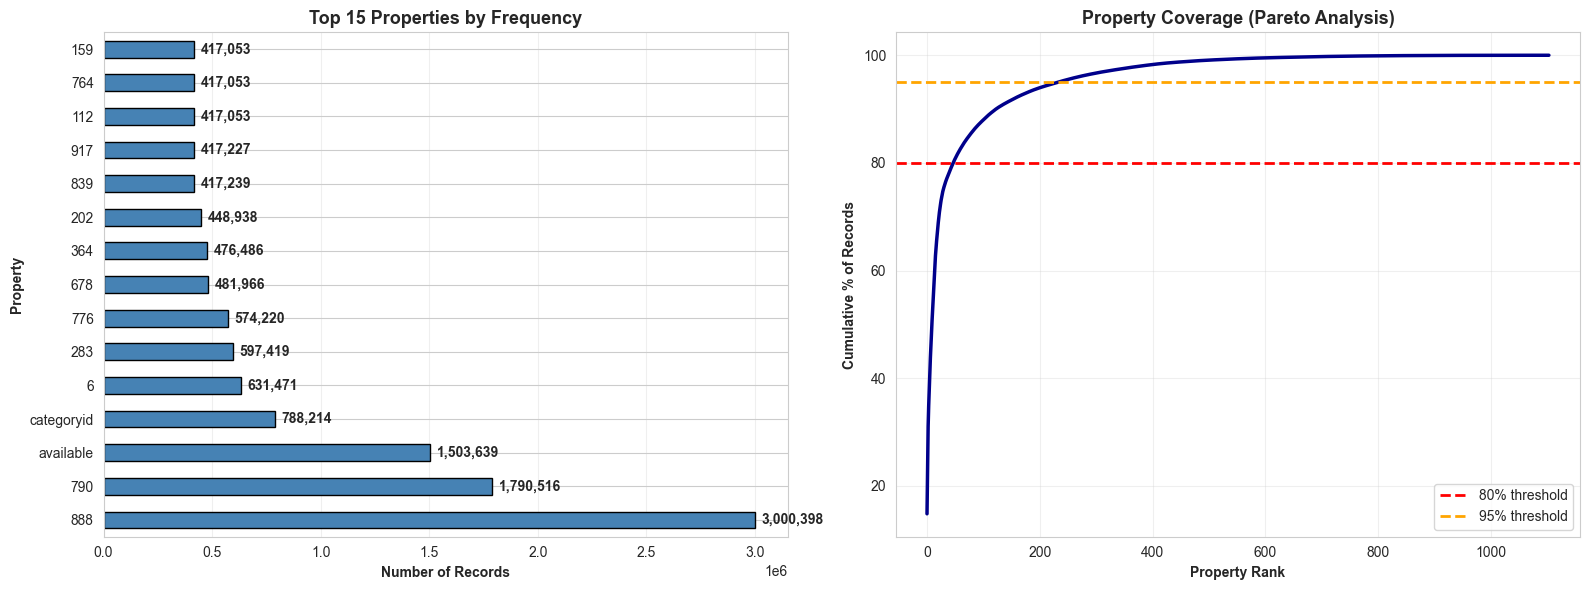


💡 Insights:
   47 properties cover 80% of records
   233 properties cover 95% of records
   Long tail: 871 rare properties (5% of data)


In [ ]:
print("\nPROPERTY DISTRIBUTION ANALYSIS")
print("="*70)

# Property frequency
property_counts = item_props['property'].value_counts()
print(f"\nTotal unique properties: {len(property_counts)}")
print(f"\nTop 20 properties:")
print(property_counts.head(20).to_string())

# Visualize top properties
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 15 properties
ax = axes[0]
top_props = property_counts.head(15)
top_props.plot(kind='barh', ax=ax, color='steelblue', edgecolor='black')
ax.set_xlabel('Number of Records', fontweight='bold')
ax.set_ylabel('Property', fontweight='bold')
ax.set_title('Top 15 Properties by Frequency', fontweight='bold', fontsize=13)
ax.grid(True, alpha=0.3, axis='x')
for i, v in enumerate(top_props.values):
    ax.text(v + max(top_props)*0.01, i, f'{v:,}', va='center', fontweight='bold')

# Pareto chart (cumulative %)
ax = axes[1]
cumsum_pct = (property_counts.cumsum() / property_counts.sum() * 100)
ax.plot(range(len(cumsum_pct)), cumsum_pct.values, linewidth=2.5, color='darkblue')
ax.axhline(y=80, color='red', linestyle='--', linewidth=2, label='80% threshold')
ax.axhline(y=95, color='orange', linestyle='--', linewidth=2, label='95% threshold')
ax.set_xlabel('Property Rank', fontweight='bold')
ax.set_ylabel('Cumulative % of Records', fontweight='bold')
ax.set_title('Property Coverage (Pareto Analysis)', fontweight='bold', fontsize=13)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Key insights
props_80pct = (cumsum_pct <= 80).sum()
props_95pct = (cumsum_pct <= 95).sum()
print(f"\n Insights:")
print(f"   {props_80pct} properties cover 80% of records")
print(f"   {props_95pct} properties cover 95% of records")
print(f"   Long tail: {len(property_counts) - props_95pct} rare properties (5% of data)")

---
## 5. Data Cleaning

In [34]:
print("\n" + "="*70)
print(" "*25 + "DATA CLEANING")
print("="*70)

print(f"\nBEFORE CLEANING: {len(item_props):,} rows")

# Remove rows with missing itemid or property
before = len(item_props)
item_props_clean = item_props.dropna(subset=['itemid', 'property']).copy()
removed = before - len(item_props_clean)
print(f"\n1. Removed records with missing itemid/property: {removed:,}")

# Convert itemid to int
item_props_clean['itemid'] = item_props_clean['itemid'].astype(int)
print(f"2. Converted itemid to integer")

# Fill missing values
item_props_clean['value'] = item_props_clean['value'].fillna('')
print(f"3. Filled missing values with empty string")

# Remove very long values (potential data quality issues)
value_lengths = item_props_clean['value'].astype(str).str.len()
very_long = (value_lengths > 1000).sum()
if very_long > 0:
    print(f"\n  Found {very_long:,} records with very long values (>1000 chars)")
    print(f"   Keeping them but noting for investigation")

print(f"\nAFTER CLEANING: {len(item_props_clean):,} rows")
print(f"Records removed: {before - len(item_props_clean):,} ({(before - len(item_props_clean))/before*100:.2f}%)")
print("\n Cleaning complete")


                         DATA CLEANING

BEFORE CLEANING: 20,275,902 rows

1. Removed records with missing itemid/property: 0
2. Converted itemid to integer
3. Filled missing values with empty string

AFTER CLEANING: 20,275,902 rows
Records removed: 0 (0.00%)

 Cleaning complete


---
## 6. Duplication

In [35]:
print("\n" + "="*70)
print(" "*25 + "DEDUPLICATION")
print("="*70)

print(f"\nBefore deduplication: {len(item_props_clean):,} rows")

# Sort by timestamp (ascending) to keep last
item_props_clean = item_props_clean.sort_values('timestamp', ascending=True)

# Keep last occurrence
item_props_dedup = item_props_clean.drop_duplicates(
    subset=['itemid', 'property'],
    keep='last'
).copy()

dupes_removed = len(item_props_clean) - len(item_props_dedup)
print(f"After deduplication:  {len(item_props_dedup):,} rows")
print(f"Duplicates removed:   {dupes_removed:,} ({dupes_removed/len(item_props_clean)*100:.2f}%)")

# Verify
remaining_dupes = item_props_dedup.duplicated(subset=['itemid', 'property']).sum()
assert remaining_dupes == 0, " Deduplication failed!"
print("\n Deduplication successful - no duplicates remain")

# Memory cleanup
del item_props, item_props_clean
print("   Cleaned up memory")


                         DEDUPLICATION

Before deduplication: 20,275,902 rows
After deduplication:  12,003,814 rows
Duplicates removed:   8,272,088 (40.80%)

 Deduplication successful - no duplicates remain
   Cleaned up memory


---
## 7. Pivot to Wide Format

In [36]:
print("\n" + "="*70)
print(" "*20 + "PIVOTING TO WIDE FORMAT")
print("="*70)

# Pivot
try:
    item_features = item_props_dedup.pivot(
        index='itemid',
        columns='property',
        values='value'
    ).reset_index()
    
    print(f" Pivot successful!")
    print(f"   Shape: {item_features.shape[0]:,} items × {item_features.shape[1]} properties")
    print(f"   Memory: {item_features.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
    
except Exception as e:
    print(f" Pivot failed: {e}")
    print("\nTrying alternative approach...")
    # Alternative: use groupby + unstack
    item_features = item_props_dedup.set_index(['itemid', 'property'])['value'].unstack().reset_index()
    print(f" Alternative method successful!")
    print(f"   Shape: {item_features.shape[0]:,} items × {item_features.shape[1]} properties")

# Clean up column names
item_features.columns.name = None

print(f"\nAvailable columns (first 20):")
print(item_features.columns.tolist()[:20])


                    PIVOTING TO WIDE FORMAT
 Pivot successful!
   Shape: 417,053 items × 1105 properties
   Memory: 14511.5 MB

Available columns (first 20):
['itemid', '0', '1', '10', '100', '1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '101', '1010', '1011', '1012', '1013']


---
## 8. Extract Key Features

In [37]:
print("\n" + "="*70)
print(" "*20 + "EXTRACTING KEY FEATURES")
print("="*70)

# Start with itemid
item_features_final = pd.DataFrame({'itemid': item_features['itemid']})
features_extracted = []

# Extract categoryid
if 'categoryid' in item_features.columns:
    item_features_final['categoryid'] = pd.to_numeric(
        item_features['categoryid'], 
        errors='coerce'
    )
    non_null = item_features_final['categoryid'].notna().sum()
    print(f"\n categoryid: {non_null:,} items ({non_null/len(item_features_final)*100:.1f}% coverage)")
    features_extracted.append('categoryid')
else:
    print("\n  categoryid not found")

# Extract available
if 'available' in item_features.columns:
    item_features_final['is_available'] = pd.to_numeric(
        item_features['available'],
        errors='coerce'
    ).fillna(0).astype(int)
    available_count = item_features_final['is_available'].sum()
    print(f" is_available: {available_count:,} available ({available_count/len(item_features_final)*100:.1f}%)")
    features_extracted.append('is_available')
else:
    print("  available not found")

# Check for other useful properties
useful_props = ['price', 'title', 'brand', 'color', 'size']
for prop in useful_props:
    if prop in item_features.columns:
        item_features_final[prop] = item_features[prop]
        non_null = item_features_final[prop].notna().sum()
        print(f" {prop}: {non_null:,} items ({non_null/len(item_features_final)*100:.1f}% coverage)")
        features_extracted.append(prop)

print(f"\n Final Dataset:")
print(f"   Items: {len(item_features_final):,}")
print(f"   Features: {len(item_features_final.columns)} ({', '.join(features_extracted)})")
print(f"   Memory: {item_features_final.memory_usage(deep=True).sum() / 1024**2:.1f} MB")


                    EXTRACTING KEY FEATURES

 categoryid: 417,053 items (100.0% coverage)
 is_available: 54,010 available (13.0%)

 Final Dataset:
   Items: 417,053
   Features: 3 (categoryid, is_available)
   Memory: 9.5 MB


In [38]:
# Display sample
print("\nSample of final dataset:")
item_features_final.head(10)


Sample of final dataset:


,itemid,categoryid,is_available
0,0,209,0
1,1,1114,0
2,2,1305,0
3,3,1171,0
4,4,1038,0
5,5,1061,0
6,6,1091,0
7,7,512,0
8,8,173,0
9,10,1301,0


---
## 9. Feature Analysis


FEATURE ANALYSIS

Category Statistics:
   Unique categories: 1,180
   Items with category: 417,053
   Items without category: 0


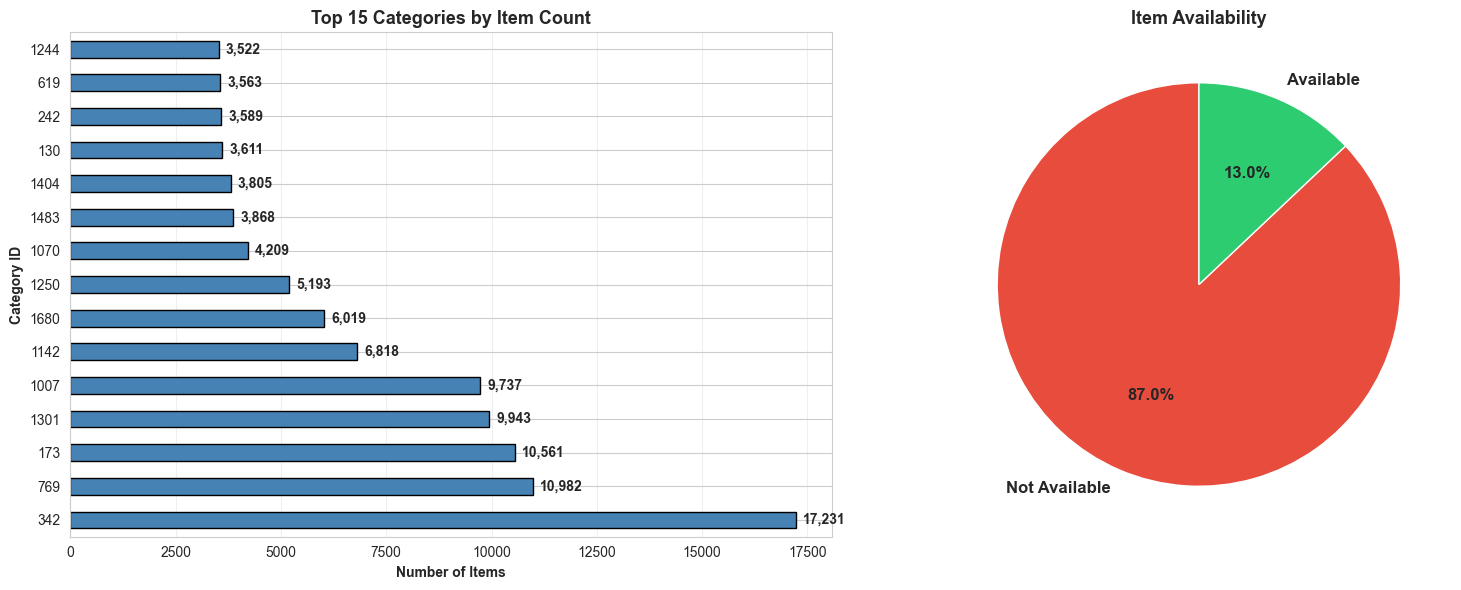


Data Completeness:
   categoryid............... 100.0%
   is_available............. 100.0%


In [39]:
print("\nFEATURE ANALYSIS")
print("="*70)

# Category distribution
if 'categoryid' in item_features_final.columns:
    print(f"\nCategory Statistics:")
    print(f"   Unique categories: {item_features_final['categoryid'].nunique():,}")
    print(f"   Items with category: {item_features_final['categoryid'].notna().sum():,}")
    print(f"   Items without category: {item_features_final['categoryid'].isna().sum():,}")
    
    # Top categories
    top_cats = item_features_final['categoryid'].value_counts().head(15)
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Top categories
    ax = axes[0]
    top_cats.plot(kind='barh', ax=ax, color='steelblue', edgecolor='black')
    ax.set_xlabel('Number of Items', fontweight='bold')
    ax.set_ylabel('Category ID', fontweight='bold')
    ax.set_title('Top 15 Categories by Item Count', fontweight='bold', fontsize=13)
    ax.grid(True, alpha=0.3, axis='x')
    for i, v in enumerate(top_cats.values):
        ax.text(v + max(top_cats)*0.01, i, f'{v:,}', va='center', fontweight='bold')
    
    # Availability
    if 'is_available' in item_features_final.columns:
        ax = axes[1]
        avail_counts = item_features_final['is_available'].value_counts()
        colors = ['#e74c3c', '#2ecc71']
        labels = ['Not Available', 'Available']
        ax.pie(avail_counts.values, labels=labels, autopct='%1.1f%%', 
               startangle=90, colors=colors, textprops={'fontsize': 12, 'fontweight': 'bold'})
        ax.set_title('Item Availability', fontweight='bold', fontsize=13)
    
    plt.tight_layout()
    plt.show()

# Data completeness summary
print(f"\nData Completeness:")
completeness = (item_features_final.notna().sum() / len(item_features_final) * 100).sort_values(ascending=False)
for col, pct in completeness.items():
    if col != 'itemid':
        print(f"   {col:.<25} {pct:>5.1f}%")

---
## 10. Save Cleaned Dataset

In [40]:
# Save as parquet (efficient)
output_path = data_extracts / 'item_features.parquet'
item_features_final.to_parquet(output_path, index=False)

print("="*70)
print(" "*20 + " DATASET SAVED")
print("="*70)
print(f"\nFile: {output_path}")
print(f"Rows: {len(item_features_final):,}")
print(f"Columns: {len(item_features_final.columns)}")
print(f"File size: {output_path.stat().st_size / 1024**2:.2f} MB")

# Also save as CSV for inspection
csv_path = data_extracts / 'item_features.csv'
item_features_final.to_csv(csv_path, index=False)
print(f"\nAlso saved CSV: {csv_path}")
print(f"CSV size: {csv_path.stat().st_size / 1024**2:.2f} MB")

print("\n Ready for Notebook 03 (Feature Engineering)!")

                     DATASET SAVED

File: /Users/rajnishpanwar/Desktop/funnel_optimization_project/data/extracts/item_features.parquet
Rows: 417,053
Columns: 3
File size: 2.47 MB

Also saved CSV: /Users/rajnishpanwar/Desktop/funnel_optimization_project/data/extracts/item_features.csv
CSV size: 5.23 MB

 Ready for Notebook 03 (Feature Engineering)!
